# Changes In The Daily Growth Rate
> Changes in the daily growth rate for select countries.

- comments: true
- author: Thomas Wiecki
- categories: [growth]
- image: images/covid-growth.png
- permalink: /growth-analysis/

In [1]:
from pathlib import Path

loadpy = Path('load_covid_data.py')
if not loadpy.exists():
    ! wget https://github.com/machine-learning-apps/covid19-dashboard/blob/master/_notebooks/load_covid_data.py

In [2]:
#hide
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import seaborn as sns

import load_covid_data

sns.set_context('talk')
plt.style.use('seaborn-whitegrid')

In [3]:
#hide
df = load_covid_data.load_data_ecdc()
    
annotate_kwargs = dict(
    s='Based on COVID Data Repository by Johns Hopkins CSSE ({})\nBy Thomas Wiecki'.format(df.index.max().strftime('%B %d, %Y')), 
    xy=(0.05, 0.01), xycoords='figure fraction', fontsize=10)

In [4]:
#hide
# Country names seem to change quite a bit
df.country.unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia',
       'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh',
       'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bermuda',
       'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Brazil', 'Brunei',
       'Bulgaria', 'Burkina Faso', 'Cambodia', 'Cameroon', 'Canada',
       'Cape Verde', 'Cayman Islands', 'Central African Republic', 'Chad',
       'Chile', 'China', 'Colombia', 'Congo', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Cuba', 'Cyprus', 'Czech Republic',
       'Democratic Republic of Congo', 'Denmark', 'Djibouti', 'Dominica',
       'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador',
       'Equatorial Guinea', 'Eritrea', 'Estonia', 'Ethiopia',
       'Faeroe Islands', 'Fiji', 'Finland', 'France', 'French Polynesia',
       'Gabon', 'Gambia', 'Georgia', 'Germany', 'Ghana', 'Gibraltar',
       'Greece', 'Greenland', 'Grena

In [5]:
#hide
european_countries = ['Italy', 'Germany', 'France', 'Spain', 'United Kingdom', 
                      'Iran']
large_engl_countries = ['United States', 'Canada', 'Australia']
asian_countries = ['Singapore', 'Japan', 'South Korea']
south_american_countries = ['Argentina', 'Brazil', 'Colombia', 'Chile']

country_groups = [european_countries, large_engl_countries, asian_countries, south_american_countries]
line_styles = ['-', ':', '--', '-.']

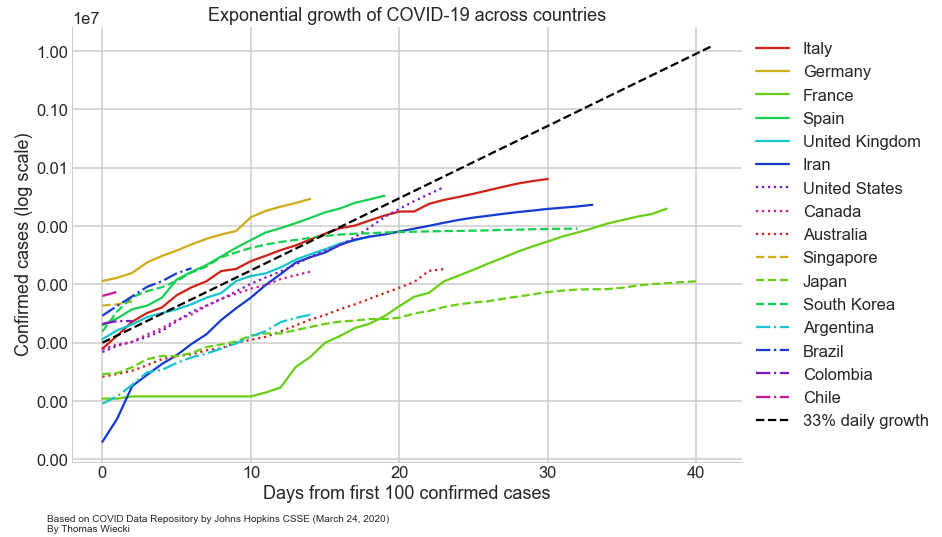

In [9]:
#hide

def plot_countries(df, countries, min_confirmed=1, ls='-', col='confirmed'):
    for country in countries:
        df_country = df.loc[(df.country == country) & (df.deaths >= min_confirmed)]
        if len(df_country) == 0:
            continue
        df_country.reset_index()[col].plot(label=country, ls=ls)
        
sns.set_palette(sns.hls_palette(8, l=.45, s=.8)) # 8 countries max
fig, ax = plt.subplots(figsize=(12, 8))

for countries, ls in zip(country_groups, line_styles):
    plot_countries(df, countries, ls=ls)

x = np.linspace(0, plt.xlim()[1] - 1)
ax.plot(x, 100 * (1.33) ** x, ls='--', color='k', label='33% daily growth')

ax.set(yscale='log',
       title='Exponential growth of COVID-19 across countries',
       xlabel='Days from first 100 confirmed cases',
       ylabel='Confirmed cases (log scale)')
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.annotate(**annotate_kwargs)
sns.despine();

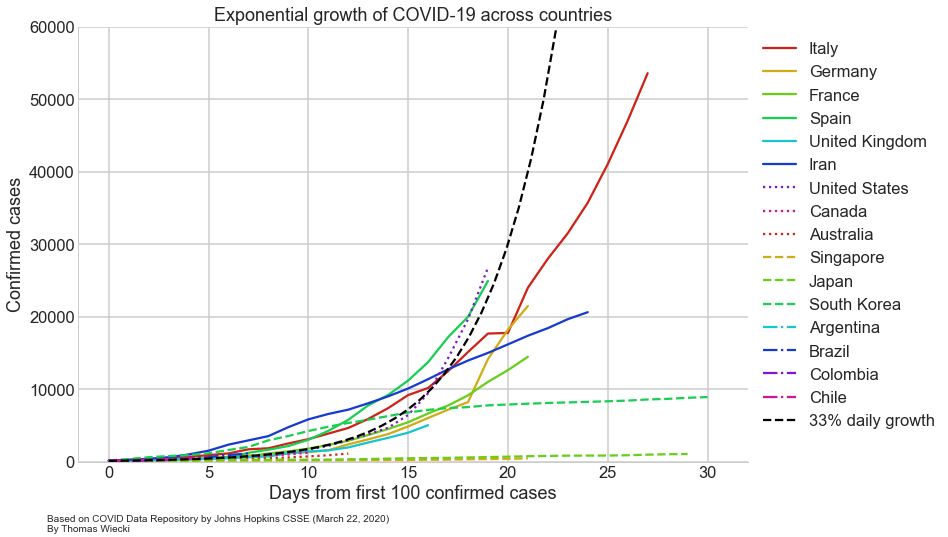

In [22]:
#hide
fig, ax = plt.subplots(figsize=(12, 8))

for countries, ls in zip(country_groups, line_styles):
    plot_countries(df, countries, ls=ls)

x = np.linspace(0, plt.xlim()[1] - 1)
ax.plot(x, 100 * (1.33) ** x, ls='--', color='k', label='33% daily growth')

ax.set(title='Exponential growth of COVID-19 across countries',
       xlabel='Days from first 100 confirmed cases',
       ylabel='Confirmed cases', ylim=(0, 60000))
ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.annotate(**annotate_kwargs)
sns.despine();

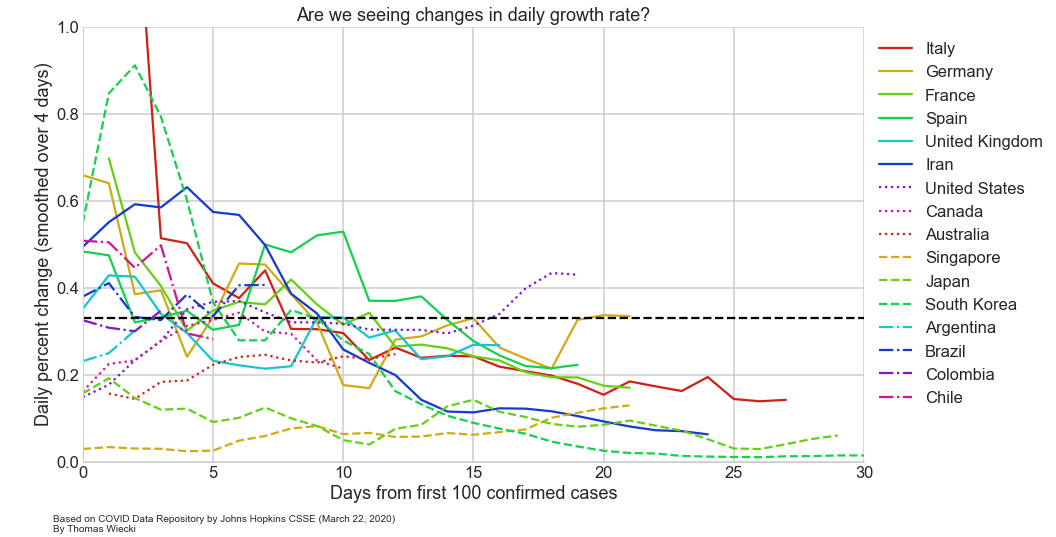

In [28]:
#hide_input
smooth_days = 4
fig, ax = plt.subplots(figsize=(14, 8))
df['pct_change'] = (df
                    .groupby('country')
                    .confirmed
                    .pct_change()
                    .rolling(smooth_days)
                    .mean()
)

for countries, ls in zip(country_groups, line_styles):
    (df.set_index('country')
       .loc[countries]
       .loc[lambda x: x.confirmed > 100]
       .reset_index()
       .set_index('days_since_100')
       .groupby('country', sort=False)['pct_change']
       .plot(ls=ls)
    )

ax.set(ylim=(0, 1),
       xlim=(0, 30),
       title='Are we seeing changes in daily growth rate?',
       xlabel='Days from first 100 confirmed cases',
       ylabel='Daily percent change (smoothed over {} days)'.format(smooth_days),
)
ax.axhline(.33, ls='--', color='k')
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.legend(bbox_to_anchor=(1.0, 1.0))
sns.despine()
ax.annotate(**annotate_kwargs);

# This creates a preview image for the blog post and home page
fig.savefig('../images/covid-growth.png')

## Appendix: German ICU Capacity

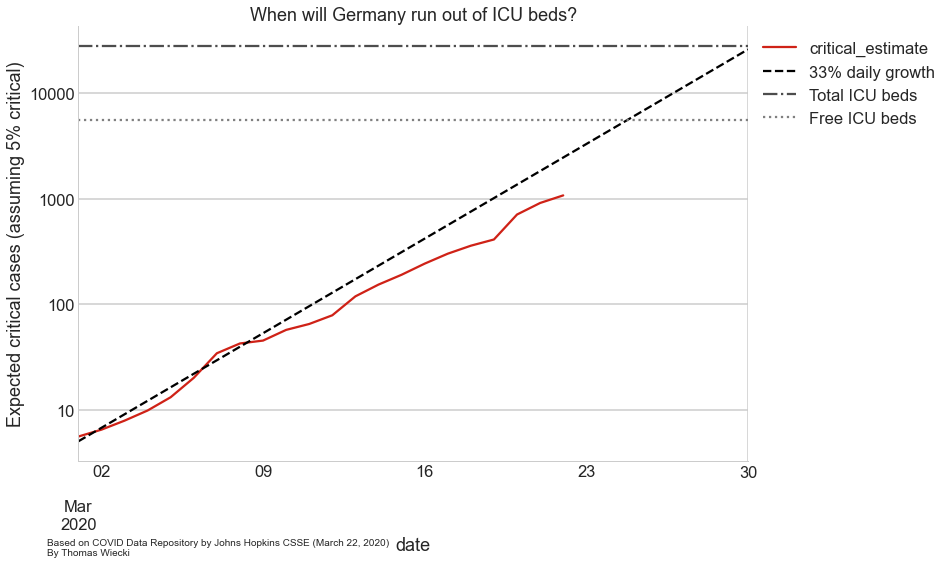

In [29]:
#collapse-hide
sns.set_palette(sns.hls_palette(8, l=.45, s=.8)) # 8 countries max
fig, ax = plt.subplots(figsize=(12, 8))
p_crit = .05
# 28000 ICU beds total, 80% occupied
icu_germany = 28000
icu_germany_free = .2

df_tmp = df.loc[lambda x: (x.country == 'Germany') & (x.confirmed > 100)].critical_estimate
df_tmp.plot(ax=ax)

x = np.linspace(0, 30, 30)
pd.Series(index=pd.date_range(df_tmp.index[0], periods=30),
          data=100*p_crit * (1.33) ** x).plot(ax=ax,ls='--', color='k', label='33% daily growth')

ax.axhline(icu_germany, color='.3', ls='-.', label='Total ICU beds')
ax.axhline(icu_germany * icu_germany_free, color='.5', ls=':', label='Free ICU beds')
ax.set(yscale='log',
       title='When will Germany run out of ICU beds?',
       ylabel='Expected critical cases (assuming {:.0f}% critical)'.format(100 * p_crit),
)
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.legend(bbox_to_anchor=(1.0, 1.0))
sns.despine()
ax.annotate(**annotate_kwargs);

Updated daily by [GitHub Actions](https://github.com/features/actions).

This visualization was made by [Thomas Wiecki](https://twitter.com/twiecki)[^1].

[^1]:  Data sourced from ["2019 Novel Coronavirus COVID-19 (2019-nCoV) Data Repository by Johns Hopkins CSSE"](https://systems.jhu.edu/research/public-health/ncov/) [GitHub repository](https://github.com/CSSEGISandData/COVID-19) and recreates the (pay-walled) plot in the [Financial Times]( https://www.ft.com/content/a26fbf7e-48f8-11ea-aeb3-955839e06441). This code is provided under the [BSD-3 License](https://github.com/twiecki/covid19/blob/master/LICENSE). Link to [original notebook](https://github.com/twiecki/covid19/blob/master/covid19_growth.ipynb).